### Quick demo of slightly hacky catalog reader for cosmoDC2_v1.1.4_image 10 year mock error PDFs
The composite catalog of a composite catalog was not working properly with one catalog using "MATCHING_ORDER" to match the 10-year scattered magnitudes to the base cosmoDC2_v1.1.4_image catalog, and then also adding the PDF files for a *subset* of that data.  So, the solution I came up with was to create a composite catalog that matches the 10 year scattered photometry to the subset of objects with PDFs via a match by galaxy_id.  As the base scattered magnitudes are a line for line match to the cosmoDC2v1.1.4_image catalog, we can use the masked arrays from that catalog to also mask quantities in the base catalog, we just need to load both catalogs separately into readers and make sure that we make the *exact* cuts on each.  <br>

The new catalog is named `photoz_magerr_10y_with_pdfs`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from matplotlib.colors import LogNorm

NOTE: THIS `sys.path.insert` IS NO LONGER NECESSARY, branch has been merged into master in gcr-catalogs!<br>
#Load the local copy of gcr-catalogs branch that has the new catalog definitions, this branch is named
#`u/sschmidt23/mockpdfreader`<br>
#which can be found at:<br>
#https://github.com/LSSTDESC/gcr-catalogs/tree/u/sschmidt23/mockpdfreader

In [2]:
#sys.path.insert(0,"/global/homes/s/schmidt9/PZDC2/GCRreader/gcr-catalogs/lib/python3.7/site-packages/GCRCatalogs-0.14.4-py3.7.egg")

In [2]:
import GCRCatalogs

In [3]:
import GCR
GCR.__version__

'0.8.8'

In [4]:
GCRCatalogs.__version__

'0.17.0'

In [6]:
#print('\n'.join(sorted(GCRCatalogs.get_available_catalogs(False))))

To start, load both catalogs 

In [5]:
cat = GCRCatalogs.load_catalog('photoz_magerr_10y_with_pdfs')
cat2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [7]:
cat2.cosmology

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=0.0448)

In [7]:
#print(cat2.get_catalog_info())

Let's list all of the quantities available in `photoz_magerr_10y_with_pdfs`, which includes the galaxy_id, point estimate statistics, and PDF estimates.  Note: some column names are listed twice with slightly different names, e.g. `photoz_mode` and `point_estimates/z_mode`, this is due to an alias created in GCRCatalogs.  Either name is fine and will return the same data.

In [6]:
#print('\n'.join(sorted(cat.list_all_quantities())))

baseDC2/galaxy_id
galaxy_id
id/galaxy_id
pdf/pdf
photoz_mean
photoz_median
photoz_mode
photoz_mode_ml
photoz_mode_ml_red_chi2
photoz_odds
photoz_pdf
point_estimates/ODDS
point_estimates/z_mean
point_estimates/z_median
point_estimates/z_mode
point_estimates/z_mode_ml
point_estimates/z_mode_ml_red_chi2
redshift
scaterr_g
scaterr_i
scaterr_r
scaterr_u
scaterr_y
scaterr_z
scatmag_g
scatmag_i
scatmag_r
scatmag_u
scatmag_y
scatmag_z


In [8]:
#choose some columns to load from each catalog
cols = ['photoz_mode','redshift']
colmag = ['scatmag_i']
#cols_c = ['redshift','galaxy_id']#to be able to load in catalog, bit of a hack
cols2 = ['redshift', 'Mag_true_i_lsst_z0']

In [10]:
#print(cat._native_filter_quantities)

In [58]:
#I tested that the iterator returns things in the exact same order, so loading both with this form works, but we'll comment out for now and just use a couple healpix pixels as an example
#gc_it = cat.get_quantities(cols,return_iterator=True)
#gc_it2 = cat2.get_quantities(cols2,return_iterator=True)


### masked arrays
Note that a composite catalog matched by galaxy_id or other quantity returns masked arrays of the length of the longer of the two catalogs.  In order to select only objects with matches you will have to mask out the non-matching entries (somewhat non-intuitively by taking the inverse of the mask).  See examples below.

In [9]:
data1 = cat.get_quantities(cols)

In [10]:
data2 = cat2.get_quantities(cols2)

In [11]:
datamag = cat.get_quantities(colmag)

In [9]:
#datamagerr = cat.get_quantities(['scaterr_i'])

In [10]:
print(data2.keys())

dict_keys(['Mag_true_i_lsst_z0', 'redshift'])


In [13]:
sz = data1['redshift']
#id = data1['galaxy_id']
zb = data1['photoz_mode']
imag = datamag['scatmag_i']
#odds = data1['photoz_odds']
sz2 = data2['redshift']
Mrest = data2['Mag_true_i_lsst_z0']
#imagerr = datamagerr['scaterr_i']
print(len(zb))
print(len(sz))
print(len(sz2))
#print(len(imagerr))
#we see that both redshift columns have the same number of entries, things have loaded properly
print(zb)
#and we see that the zb entries have been padded with masked values of '--'

2256249331
2256249331
2256249331
[0.03500000014901161 0.0949999988079071 0.054999999701976776 ... -- -- --]


Note the double dashes in the entries for zb above, these are the entries that will be masked out.  While it appears at first glance that zb has 17.2 million entries, only a small subset actually contain data.

In [14]:
mask = ~zb.mask

In [16]:
szcut = sz[mask]
zbcut = zb[mask]
imagcut = imag[mask]
#oddscut = odds[mask]
sz2cut = sz2[mask]
Mrestcut = Mrest[mask]
#imagerrcut = imagerr[mask]
print(len(szcut))
print(len(zbcut))
print(len(sz2cut))
print(len(Mrestcut))
#print(len(imagerrcut))

208621534
208621534
208621534
208621534


Now that the proper mask has been applied, we see that only 1.58 million of the 17.2 million entries actually have photo-z estimates, these are the data that we actually want to use.  To check that the ordering is properly preserved, let's plot the redshift from catalog2 against the photoz_mode from catalog1.

In [17]:
## cut photoz >= 0.1  & < 2.0
zminmask = (zbcut >= 0.1) #& (zbcut < 2.0)
szmin = szcut[zminmask]
zbmin = zbcut[zminmask]
imagmin = imagcut[zminmask]
sz2min = sz2cut[zminmask]
Mrestmin = Mrestcut[zminmask]
#imagerrmin = imagerrcut[zminmask]
print(len(szmin))
print(len(zbmin))
print(len(sz2min))
print(len(Mrestmin))
#print(len(imagerrmin))

208243603
208243603
208243603
208243603


In [18]:
nmagmask = (imagmin<26.5)
sz2faint = sz2min[nmagmask]
szfaint = szmin[nmagmask]
zbfaint = zbmin[nmagmask]
#oddsfaint = oddscut[nmagmask]
imagfaint = imagmin[nmagmask]
Mrestfaint = Mrestmin[nmagmask]
#imagerrfaint = imagerrmin[nmagmask]

print(len(zbfaint))
#print(len(oddsfaint))
print(len(imagfaint))
print(len(Mrestfaint))
#print(len(imagerrfaint))

206001065
206001065
206001065


Text(0, 0.5, 'photo-z mode')

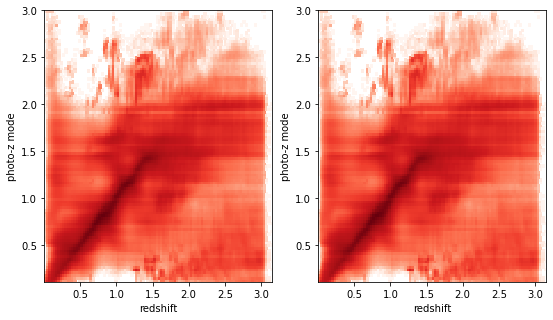

In [20]:
fig, ax = plt.subplots(1,2, figsize=(9,5))
a = ax[0].hist2d(sz2faint, zbfaint, bins=(100, 100), cmap=plt.cm.Reds, norm=LogNorm())
b = ax[1].hist2d(szfaint, zbfaint, bins=(100, 100), cmap=plt.cm.Reds, norm=LogNorm())
ax[0].set_xlabel('redshift')
ax[0].set_ylabel('photo-z mode')
ax[1].set_xlabel('redshift')
ax[1].set_ylabel('photo-z mode')
#ax[0].set_ylim(0.0, 0.5)
#plt.savefig('n_sample_photoz_redshift.png')

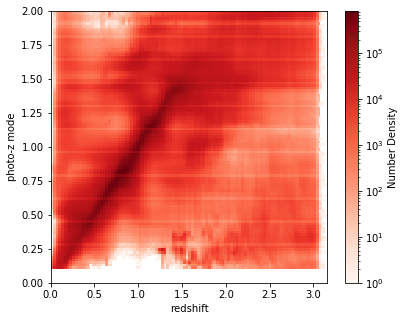

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6.2,5))
a = ax.hist2d(sz2faint, zbfaint, bins=(100, 100), cmap=plt.cm.Reds, norm=LogNorm())
ax.set_xlabel('redshift')
ax.set_ylabel('photo-z mode')
ax.set_ylim(0.0,2.0)
cbar = plt.colorbar(a[3], ax=ax)
cbar.ax.set_ylabel('Number Density')
plt.savefig('n_sample_photoz_redshift.pdf')

Even this subset contains photo-z's that we probably shouldn't use: the S/N of i-band at i~26.5 is about 5, we really want an i<25.0 cut for high quality photo-z's, only about 488k of the galaxies in these two healpix pixels meet this more stringent cut.

In [21]:
magmask = (imagmin<25.3)
sz2gold = sz2min[magmask]
zbgold = zbmin[magmask]
#oddsgold = oddscut[magmask]
imaggold = imagmin[magmask]
Mrestgold = Mrestmin[magmask]
#imagerrgold = imagerrmin[magmask]
print(len(zbgold))
#print(len(oddsgold))
print(len(imaggold))
print(len(Mrestgold))
#print(len(imagerrgold))

80150499
80150499
80150499


In [16]:
#fig = plt.figure(figsize=(10,10))
#plt.scatter(sz2gold[::10],zbgold[::10],s=2,c='r')
#plt.plot([0,3],[0,3],'k--')
#plt.xlabel('redshift',fontsize=18)
#plt.ylabel('photoz_mode',fontsize=18)

These now look appropriately well behaved, and we finally have a dataset of the form that we might want to use.

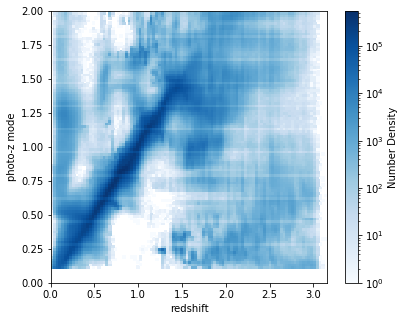

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6.2,5))
a = ax.hist2d(sz2gold, zbgold, bins=(100, 100), cmap=plt.cm.Blues, norm=LogNorm())
ax.set_xlabel('redshift')
ax.set_ylabel('photo-z mode')
ax.set_ylim(0.0,2.0)
cbar = plt.colorbar(a[3], ax=ax)
cbar.ax.set_ylabel('Number Density')
plt.savefig('e_sample_photoz_redshift.pdf')

## save cut catalog

In [19]:
print(len(sz2faint), len(np.array(zbfaint)), len(imagfaint), len(Mrestfaint)) #, len(imagerrfaint))
n_sample = np.column_stack((sz2faint, np.array(zbfaint), imagfaint, Mrestfaint)) #, imagerrfaint))
print(n_sample[:,0].shape)

print(np.array_equal(sz2faint, n_sample[:,0]))
print(np.array_equal(zbfaint, n_sample[:,1]))
print(np.array_equal(imagfaint, n_sample[:,2]))
print(np.array_equal(Mrestfaint, n_sample[:,3]))
#print(np.array_equal(imagerrfaint, n_sample[:,4]))

#np.save('n_sample_for_Nz_imag_Mrest_imagerr_included', n_sample)
np.save('n_sample_for_Nz_imag_Mrest_included_no_max_zphot_cut', n_sample)

n_test = np.load('n_sample_for_Nz_imag_Mrest_included_no_max_zphot_cut.npy')
print(np.array_equal(n_test, n_sample[:,:4]))

206001065 206001065 206001065 206001065
(206001065,)
True
True
True
True
True


In [22]:
print(len(sz2gold), len(np.array(zbgold)), len(imaggold), len(Mrestgold)) #, len(imagerrgold))
e_sample = np.column_stack((sz2gold, np.array(zbgold), imaggold, Mrestgold)) #, imagerrgold))
print(e_sample[:,0].shape)

print(np.array_equal(sz2gold, e_sample[:,0]))
print(np.array_equal(zbgold, e_sample[:,1]))
print(np.array_equal(imaggold, e_sample[:,2]))
print(np.array_equal(Mrestgold, e_sample[:,3]))
#print(np.array_equal(imagerrgold, e_sample[:,4]))

np.save('e_sample_for_Nz_imag_Mrest_included_no_max_zphot_cut', e_sample)

e_test = np.load('e_sample_for_Nz_imag_Mrest_included_no_max_zphot_cut.npy')
np.array_equal(e_test, e_sample)

80150499 80150499 80150499 80150499
(80150499,)
True
True
True
True


True